In [2]:
import os
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import pickle

warnings.filterwarnings('ignore')

In [4]:
filename = r'C:\Users\pc\Desktop\Semester 6\Information Retrieval\Projects\Sarcasm Detection - Feature selection\news-headlines-dataset-for-sarcasm-detection\Sarcasm_Headlines_Dataset.json'
data = []
with open(filename, "r") as file:
    for line in file:
        data.append(json.loads(line))

In [5]:
df = pd.DataFrame(data)
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [6]:
df = df.drop('article_link', axis = 1)
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [8]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [9]:
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(df['headline'])
y = df['is_sarcastic']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
def select_k_best(X_train, X_test, y_train, k=500):
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return selector, X_train_selected, X_test_selected

In [13]:
def select_mutual_info(X_train, X_test, y_train, k=500):
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return selector, X_train_selected, X_test_selected

In [14]:
def apply_pca(X_train, X_test, n_components=500):
    pca = TruncatedSVD(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return pca, X_train_pca, X_test_pca

In [15]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['non-sarcastic', 'sarcastic']))
    return clf, classification_report(y_test, y_pred, output_dict=True)

In [16]:
Kbest, X_train_selected_k_best, X_test_selected_k_best = select_k_best(X_train, X_test, y_train)
_, result_k_best = train_and_evaluate(X_train_selected_k_best, X_test_selected_k_best, y_train, y_test)

               precision    recall  f1-score   support

non-sarcastic       0.86      0.73      0.79      2996
    sarcastic       0.71      0.85      0.78      2346

     accuracy                           0.78      5342
    macro avg       0.79      0.79      0.78      5342
 weighted avg       0.80      0.78      0.78      5342



In [17]:
mutual_info, X_train_selected_mutual_info, X_test_selected_mutual_info = select_mutual_info(X_train, X_test, y_train)
_, result_mutual_info = train_and_evaluate(X_train_selected_mutual_info, X_test_selected_mutual_info, y_train, y_test)

               precision    recall  f1-score   support

non-sarcastic       0.83      0.78      0.80      2996
    sarcastic       0.74      0.80      0.76      2346

     accuracy                           0.79      5342
    macro avg       0.78      0.79      0.78      5342
 weighted avg       0.79      0.79      0.79      5342



In [18]:
pca, X_train_pca, X_test_pca = apply_pca(X_train, X_test)
_, result_pca = train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test)

               precision    recall  f1-score   support

non-sarcastic       0.85      0.81      0.83      2996
    sarcastic       0.77      0.81      0.79      2346

     accuracy                           0.81      5342
    macro avg       0.81      0.81      0.81      5342
 weighted avg       0.81      0.81      0.81      5342



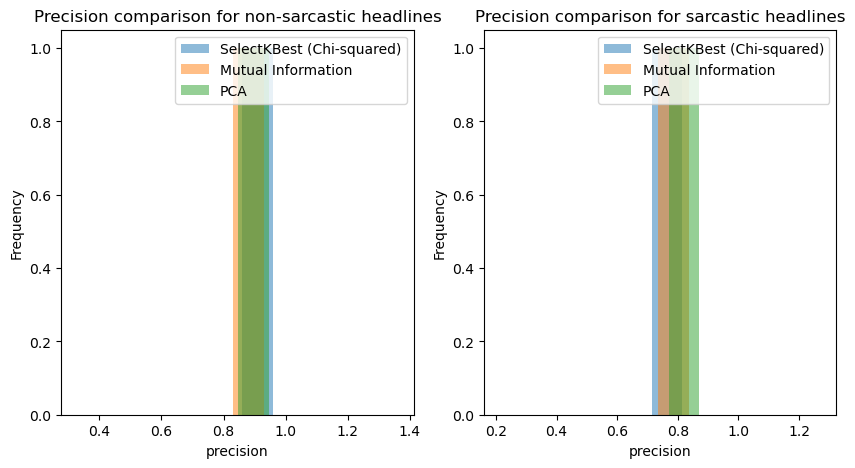

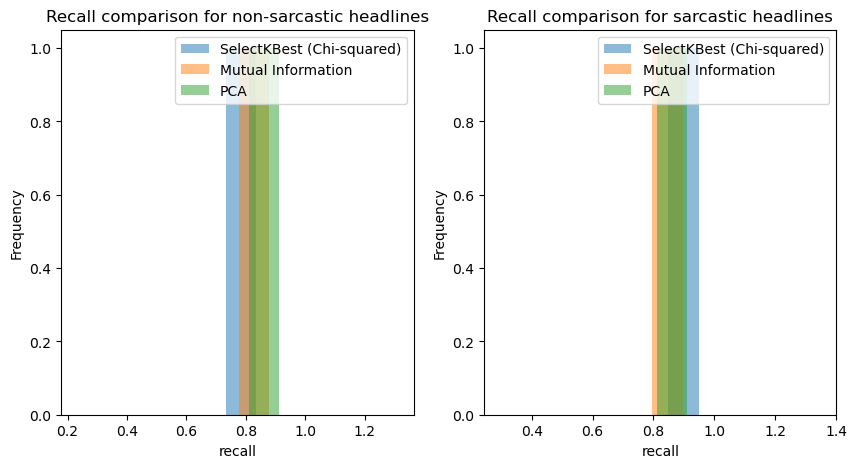

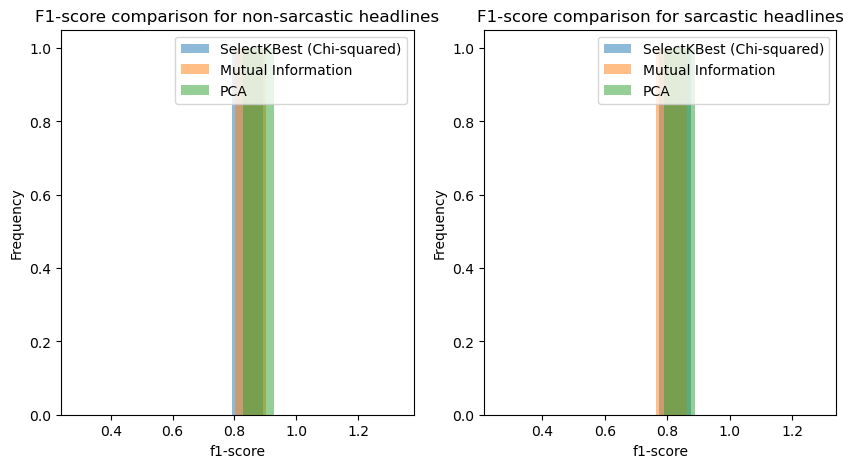

In [19]:
metrics = ['precision', 'recall', 'f1-score']
categories = ['non-sarcastic', 'sarcastic']

for metric in metrics:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].hist(result_k_best['0'][metric], label='SelectKBest (Chi-squared)', alpha=0.5)
    ax[0].hist(result_mutual_info['0'][metric], label='Mutual Information', alpha=0.5)
    ax[0].hist(result_pca['0'][metric],  label='PCA', alpha=0.5)
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel(metric)
    ax[0].set_title(f'{metric.capitalize()} comparison for non-sarcastic headlines')
    ax[0].legend()

    ax[1].hist(result_k_best['1'][metric], label='SelectKBest (Chi-squared)', alpha=0.5)
    ax[1].hist(result_mutual_info['1'][metric], label='Mutual Information', alpha=0.5)
    ax[1].hist(result_pca['1'][metric], label='PCA', alpha=0.5)
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlabel(metric)
    ax[1].set_title(f'{metric.capitalize()} comparison for sarcastic headlines')
    ax[1].legend()
    plt.show()


In [20]:
X_train_merged = np.concatenate((X_train_selected_k_best.toarray(), X_train_selected_mutual_info.toarray(), X_train_pca), axis=1)
X_test_merged = np.concatenate((X_test_selected_k_best.toarray(), X_test_selected_mutual_info.toarray(), X_test_pca), axis=1)

In [21]:
final_model, _ = train_and_evaluate(X_train_merged, X_test_merged, y_train, y_test)

               precision    recall  f1-score   support

non-sarcastic       0.85      0.81      0.83      2996
    sarcastic       0.77      0.82      0.79      2346

     accuracy                           0.81      5342
    macro avg       0.81      0.81      0.81      5342
 weighted avg       0.81      0.81      0.81      5342



In [22]:
with open('final_svm_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('Kbest.pkl', 'wb') as f:
    pickle.dump(Kbest, f)
with open('mutual_info.pkl', 'wb') as f:
    pickle.dump(mutual_info, f)
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

Main Execution

In [26]:
def predict_sarcasm():
    text = entry.get()
    with open('final_svm_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    with open('Kbest.pkl', 'rb') as f:
        Kbest = pickle.load(f)
    with open('mutual_info.pkl', 'rb') as f:
        mutual_info = pickle.load(f)
    with open('pca.pkl', 'rb') as f:
        pca = pickle.load(f)
    text_vectorized = vectorizer.transform([text])
    X_test_selected_k_best = Kbest.transform(text_vectorized)
    X_test_selected_mutual_info = mutual_info.transform(text_vectorized)
    X_test_pca = pca.transform(text_vectorized)
    X_test_merged = np.concatenate((X_test_selected_k_best.toarray(), 
                                    X_test_selected_mutual_info.toarray(), 
                                    X_test_pca), axis=1)
    prediction = model.predict(X_test_merged)
    result_label.config(text="Sarcastic" if prediction[0] else "Not Sarcastic")

In [27]:
root = tk.Tk()
root.title("Sarcasm Detection")

entry_label = ttk.Label(root, text="Enter a headline:")
entry_label.grid(row=0, column=0, padx=10, pady=10)
entry = ttk.Entry(root, width=50)
entry.grid(row=0, column=1, padx=10, pady=10)

predict_button = ttk.Button(root, text="Predict", command=predict_sarcasm)
predict_button.grid(row=1, column=0, columnspan=2, padx=10, pady=10)

result_label = ttk.Label(root, text="")
result_label.grid(row=2, column=0, columnspan=2, padx=10, pady=10)

root.mainloop()